End-To-End ML Data Pipeline 
* Come up with ML model in Jupyter notebook + basic feature engineering on ecommerce dataset, using 3-5 features 
* Save model binary and model version in AI-Platform 
* Create google BQ table, pub/sub topic, and simple google DataFlow DAG for feature engineering

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [9]:
data = pd.read_csv('ecommerce.csv')
data

,fullVisitorId,channelGrouping,time,country,city,totalTransactionRevenue,transactions,timeOnSite,pageviews,sessionQualityDim,...,itemQuantity,itemRevenue,transactionRevenue,transactionId,pageTitle,searchKeyword,pagePathLevel1,eCommerceAction_type,eCommerceAction_step,eCommerceAction_option
0,8074041050560984021,Organic Search,374400,United States,Mountain View,NaN,NaN,923.0,34,75,...,NaN,NaN,NaN,NaN,NaN,NaN,/storeitem.html,0,1,NaN
1,8074041050560984021,Organic Search,572599,United States,Mountain View,NaN,NaN,923.0,34,75,...,NaN,NaN,NaN,NaN,NaN,NaN,/storeitem.html,0,1,NaN
2,8685530477324183365,Display,772010,Singapore,(not set),NaN,NaN,837.0,39,10,...,NaN,NaN,NaN,NaN,NaN,NaN,/storeitem.html,0,1,NaN
3,3395445735354444853,Direct,1110096,United States,Mountain View,NaN,NaN,1701.0,40,75,...,NaN,NaN,NaN,NaN,NaN,NaN,/storeitem.html,0,1,NaN
4,3173566250804266498,Organic Search,840497,United States,San Jose,NaN,NaN,1102.0,14,46,...,NaN,NaN,NaN,NaN,NaN,NaN,/storeitem.html,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,6058824385240462779,Organic Search,709388,Dominican Republic,not available in demo dataset,NaN,NaN,832.0,27,13,...,NaN,NaN,NaN,NaN,Accessories | Google Merchandise Store,NaN,/google+redesign/,0,1,NaN
15996,6058824385240462779,Organic Search,693137,Dominican Republic,not available in demo dataset,NaN,NaN,832.0,27,13,...,NaN,NaN,NaN,NaN,Accessories | Google Merchandise Store,NaN,/google+redesign/,0,1,NaN
15997,6058824385240462779,Organic Search,693137,Dominican Republic,not available in demo dataset,NaN,NaN,832.0,27,13,...,NaN,NaN,NaN,NaN,Accessories | Google Merchandise Store,NaN,/google+redesign/,0,1,NaN
15998,6058824385240462779,Organic Search,696718,Dominican Republic,not available in demo dataset,NaN,NaN,832.0,27,13,...,NaN,NaN,NaN,NaN,Accessories | Google Merchandise Store,NaN,/google+redesign/,0,1,NaN


In [10]:
# we see that there are 3 classes of actions 

data.eCommerceAction_step.value_counts(normalize=True)*100

1    94.64375
2     3.45000
3     1.90625
Name: eCommerceAction_step, dtype: float64

In [11]:
# we see there are 700+ unique customers who made transactions
visits = data.groupby('fullVisitorId').count().time
data = data.groupby('fullVisitorId').mean()
data['visits'] = visits
data


,time,totalTransactionRevenue,transactions,timeOnSite,pageviews,sessionQualityDim,date,visitId,productRefundAmount,productQuantity,productPrice,productRevenue,itemQuantity,itemRevenue,transactionRevenue,searchKeyword,eCommerceAction_type,eCommerceAction_step,visits
fullVisitorId,,,,,,,,,,,,,,,,,,,
122544416887869,595248.000000,87540000.0,1.0,996.00,21.125000,70.125000,20170801.0,1.501647e+09,NaN,1.90,5.279031e+07,29180000.0,NaN,NaN,87540000.0,NaN,3.125000,1.281250,32
7309054006282156,13166.000000,NaN,NaN,37.00,3.000000,1.000000,20170801.0,1.501620e+09,NaN,NaN,1.515667e+07,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,12
9218719302410506,256650.000000,NaN,NaN,485.00,14.000000,3.000000,20170801.0,1.501652e+09,NaN,NaN,1.785733e+07,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,60
13067809475143792,100688.353846,NaN,NaN,309.00,10.784615,1.815385,20170801.0,1.501584e+09,NaN,NaN,4.922123e+07,NaN,NaN,NaN,NaN,NaN,0.323077,1.000000,65
16545533464626305,118705.750000,128000000.0,1.0,298.00,16.000000,88.000000,20170801.0,1.501646e+09,NaN,1.00,1.683750e+08,128000000.0,NaN,NaN,128000000.0,NaN,2.375000,1.187500,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948594961638219978,195838.878049,NaN,NaN,605.00,25.000000,44.000000,20170801.0,1.501617e+09,NaN,NaN,2.086927e+07,NaN,NaN,NaN,NaN,NaN,0.073171,1.000000,41
9969093760255285024,0.000000,NaN,NaN,NaN,1.000000,1.000000,20170801.0,1.501588e+09,NaN,NaN,3.749000e+07,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,12
9975174095652116119,59715.166667,NaN,NaN,103.75,3.250000,4.000000,20170801.0,1.501608e+09,NaN,1.00,1.973333e+08,NaN,NaN,NaN,NaN,NaN,0.750000,1.000000,12


In [12]:
# perform min-max normalization on e-commerce action step to get liklihood of user making a purchase
df = data.eCommerceAction_step
data['purchase_probability'] = (df-df.min())/(df.max()-df.min())
data.eCommerceAction_step.unique()

array([1.28125   , 1.        , 1.1875    , 1.18181818, 1.27777778,
       1.48275862, 1.21052632, 1.13043478, 1.05357143, 1.375     ,
       1.30769231, 1.5       , 1.07142857, 1.4       , 1.26315789,
       1.03333333, 1.11764706, 1.2       , 1.33333333, 1.10344828,
       1.14814815, 1.13333333, 1.05555556, 1.44444444, 1.26086957,
       2.25      , 1.15789474, 1.17241379, 1.6       , 1.23076923,
       1.125     , 1.25      , 1.352     , 1.18518519, 1.32      ,
       1.45454545, 1.05405405, 1.18      , 1.66666667, 1.42857143,
       1.07407407, 1.46153846, 1.36      , 1.17391304, 1.07894737,
       1.20512821, 1.75      , 1.86666667, 1.11111111, 1.62222222,
       1.12      , 1.16216216, 1.20108696, 1.06666667, 1.32876712,
       1.68965517, 1.31034483, 1.13636364, 1.29411765, 1.10714286,
       1.34285714, 1.51219512, 1.31578947, 1.03846154, 1.04347826,
       1.54545455, 1.05      , 1.08333333, 1.24615385, 1.17021277,
       1.16666667, 1.57534247, 1.21428571, 1.39130435, 2.     

In [13]:
data.isna().sum()

time                         0
totalTransactionRevenue    674
transactions               674
timeOnSite                  75
pageviews                    0
sessionQualityDim            0
date                         0
visitId                      0
productRefundAmount        769
productQuantity            546
productPrice                 0
productRevenue             674
itemQuantity               769
itemRevenue                769
transactionRevenue         674
searchKeyword              769
eCommerceAction_type         0
eCommerceAction_step         0
visits                       0
purchase_probability         0
dtype: int64

In [14]:
# use only selected columns

important_cols = ['timeOnSite', 'pageviews', 'sessionQualityDim', 'productPrice', 'purchase_probability', 'visits']
data = data[important_cols].fillna(0)
data['purchased'] = data.purchase_probability.round(0).astype(int)
data.productPrice = data.productPrice / 10**6
print(data.purchased.value_counts())
data

0    762
1      7
Name: purchased, dtype: int64


,timeOnSite,pageviews,sessionQualityDim,productPrice,purchase_probability,visits,purchased
fullVisitorId,,,,,,,
122544416887869,996.00,21.125000,70.125000,52.790312,0.225000,32,0
7309054006282156,37.00,3.000000,1.000000,15.156667,0.000000,12,0
9218719302410506,485.00,14.000000,3.000000,17.857333,0.000000,60,0
13067809475143792,309.00,10.784615,1.815385,49.221231,0.000000,65,0
16545533464626305,298.00,16.000000,88.000000,168.375000,0.150000,16,0
...,...,...,...,...,...,...,...
9948594961638219978,605.00,25.000000,44.000000,20.869268,0.000000,41,0
9969093760255285024,0.00,1.000000,1.000000,37.490000,0.000000,12,0
9975174095652116119,103.75,3.250000,4.000000,197.333333,0.000000,12,0


In [15]:
from collections import Counter

# upsample imblanced classes first
Y = data.purchased
X = data.drop(columns=['purchase_probability', 'purchased'])
sm = SMOTE(sampling_strategy=1)
X_res, y_res = sm.fit_resample(X, Y)
print(Counter(y_res))

Counter({0: 762, 1: 762})


In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.2)
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
print(xgb.score(x_valid, y_valid))
print(x_valid)

0.9836065573770492
       timeOnSite  pageviews  sessionQualityDim  productPrice  visits
1371   652.945483  24.000000          83.102485     24.570871      13
1203   576.885384  15.239990          83.205162     10.178643      30
1161   444.475077  16.430507          85.734080      9.984500      24
228      0.000000   1.000000           1.000000     45.406667      12
400    228.000000   5.000000           2.000000      0.000000       3
...           ...        ...                ...           ...     ...
1375   576.135159  17.723135          44.773820     13.872731       9
1160   535.129029  15.761446          29.317636     23.770605       9
212   1254.000000   4.000000           1.000000     10.865833      12
525     99.000000   3.000000           1.000000     15.156667      12
628   2455.296296  91.425926          78.666667     21.101667      54

[305 rows x 5 columns]


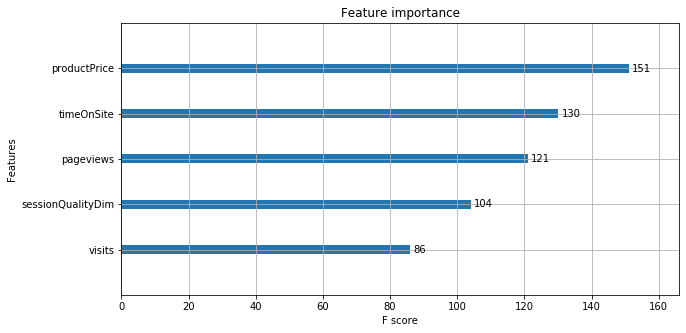

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgb, ax=ax)

In [ ]:
import sys
!{sys.executable} -m pip install imbalanced-learn xgboost sklearn

In [ ]:
# save model to binary
joblib.dump(xgb, 'model.joblib')

In [18]:
model = joblib.load('xgb.joblib')
model.predict(x_valid)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Build Dataflow Pipeline

In [4]:
import apache_beam as beam
import argparse
import json
import pandas as pd
import joblib
from apache_beam.options.pipeline_options import PipelineOptions, SetupOptions
from apache_beam.io.gcp.bigquery import WriteToBigQuery, BigQueryDisposition as bqd
from google.cloud import bigquery, storage
from datetime import datetime
from io import BytesIO
%env GOOGLE_APPLICATION_CREDENTIALS=gcp_token.json

#client = bigquery.Client.from_service_account_json('gcp_token.json')
#table = client.dataset('prediction_data', 'ml-pipeline-285203').table('predictions')
#schema = client.get_table(table).schema
#schema

env: GOOGLE_APPLICATION_CREDENTIALS=gcp_token.json


In [19]:
class Predict(beam.DoFn):

    def __init__(self):
        self._model = None
        self._storage = storage
        self._pd = pd
        self.model_file = 'model.joblib'
     
    def process(self, element):
        # get model from storage
        if self._model is None:
            blob = self._storage.Client().get_bucket('models123').get_blob(self.model_file)
            blob.download_to_file(BytesIO())
            self._model = joblib.load(self.model_file)
        
        new_x = self._pd.DataFrame.from_dict(element, orient = "index").transpose().fillna(0)   
        new_x.pageviews = float(new_x.pageviews)
        
        # predict
        prob = str(self._model.predict_proba(new_x.iloc[:, 1:])[0][1])
        return [{ 'customer_id': str(element['customer_id']), 
                  'purchase_probability': prob,
                  'model': 'XGBClassifier',
                  'datetime': str(datetime.now().strftime("%d-%m-%Y,%H:%M:%S")),
                }]

In [20]:
#parser = argparse.ArgumentParser()
#known_args, pipeline_args = parser.parse_known_args(None)
project = 'ml-pipeline-285203'
pipeline_args = {'project': project, 'runner:': 'DirectRunner', 'streaming': True} # 'project': project
pipeline_options = PipelineOptions(**pipeline_args)

# define the pipeline steps
p = beam.Pipeline(options=pipeline_options)

# groupby customer_id to get column means and visit_count
output = []
def collect(prediction):
    output.append(prediction)
    return prediction

query = " SELECT \
            customer_id, \
            SUM(session_duration) as timeOnSite, \
            SUM(page_views) as pageviews, \
            AVG(satisfaction_score) as sessionQualityDim, \
            AVG(product_price) as productPrice, \
            COUNT(*) AS visits \
          FROM `ml-pipeline-285203.raw_data.raw_data` \
          GROUP BY `customer_id`"
source = beam.io.BigQuerySource(query=query, use_standard_sql=True)
pipeline = (
    p | 'Retrieve Data' >> beam.io.Read(source)
      | 'Apply Model' >> beam.ParDo(Predict())
      | 'View Predictions' >> beam.Map(collect)
      | 'Save to BigQuery' >>  WriteToBigQuery(
                               table='ml-pipeline-285203:prediction_data.predictions',
                               schema='customer_id:INTEGER, purchase_probability:FLOAT, model:STRING, datetime:STRING',
                               create_disposition=bqd.CREATE_IF_NEEDED, 
                               write_disposition=bqd.WRITE_APPEND
                            )
)

# run the pipeline
result = p.run()
result.wait_until_finish()
#output

/Users/shengwei.pang/anaconda3/envs/datarobot/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:1479: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  experiments = p.options.view_as(DebugOptions).experiments or []
ERROR:apache_beam.runners.direct.executor:Exception at bundle <apache_beam.runners.direct.bundle_factory._Bundle object at 0x7feb6bf925f0>, due to an exception.
 Traceback (most recent call last):
  File "apache_beam/runners/common.py", line 961, in apache_beam.runners.common.DoFnRunner.process
  File "apache_beam/runners/common.py", line 554, in apache_beam.runners.common.SimpleInvoker.invoke_process
  File "<ipython-input-19-882a2e189eb0>", line 14, in process
    self._model = joblib.load(self.model_file)
  File "/Users/shengwei.pang/anaconda3/envs/datarobot/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 597, in load
    with open(filename, 'rb') as f:
FileNotFoundError: 

ERROR:apache_beam.runners.direct.executor:Giving up after 4 attempts.


RuntimeError: FileNotFoundError: [Errno 2] No such file or directory: 'model.joblib' [while running '[20]: Apply Model']

In [ ]:
# pipeline = (p | 'generate' >> beam.Create(range(10))| "print" >> beam.Map(collect))

In [ ]:
import sys
!{sys.executable} -m pip install imbalanced-learn xgboost sklearn apache-beam[interactive] google-apitools apache_beam[gcp] google-cloud-storage google-cloud-bigquery argparse

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS=gcp_token.json

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS